# Goal : Confirm with simple model monotonous strain is not complicated

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nbimporter
import random

from IPython.display import Image
from IPython.core.display import HTML 

In [14]:
from Functions import RMA_newton

Importing Jupyter notebook from Functions.ipynb


In [15]:
def strain_non_linear(N,p):
    return 0.2*np.array(range(N+1))**p/N**p

def strain_non_linear2(N,p):
    final_value = random.uniform(0,0.2)
    return final_value*np.array(range(N+1))**p/N**p

def strain_linear(N):
    final_value = random.uniform(0,0.2)
    slope       = final_value/N
    return slope * np.array(range(N+1))

### 0. Intuition in a Graph

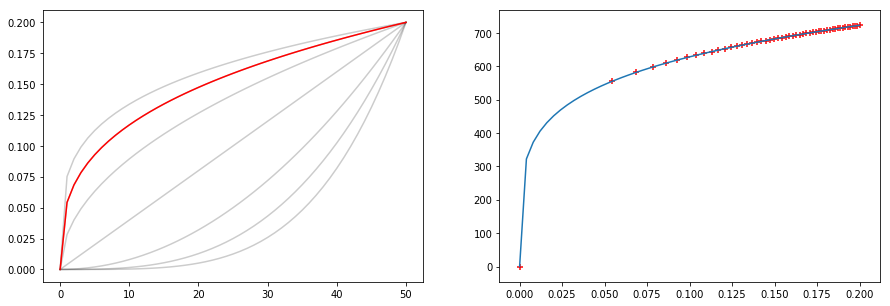

In [16]:
N=50
p=[1/4,1/3,1/2,1,2,3,4]

E = 200000
b = 0.001
A = 1000
a = 0.2

strains_int=[]
stress_int=[]

for i in range(7):
    new_strain=strain_non_linear(N,p[i])
    strains_int.append(new_strain)
    rma=RMA_newton(new_strain)
    rma.activate(E,A,b,a)
    stress_int.append(rma.stress)

plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,2,1)
for i in strains_int:
    plt.plot(i,color='k',alpha=0.2)
plt.plot(strains_int[1],color='red')
plt.subplot(1,2,2)
plt.plot(strains_int[3],stress_int[3])
#plt.scatter(strains_int[0],stress_int[0],marker='+',color='red')
plt.scatter(strains_int[1],stress_int[1],marker='+',color='red')
#plt.scatter(strains_int[2],stress_int[2],marker='+',color='red')
#plt.scatter(strains_int[4],stress_int[4],marker='+',color='red')
#plt.scatter(strains_int[5],stress_int[5],marker='+',color='red')
#plt.scatter(strains_int[6],stress_int[6],marker='+',color='red')
plt.show()

Any of the lines are going to be represented by a scatter similar to the one on the strain-stress diagram. The problem we are trying to solve is therefore approximating statistically a continuous function.

### I. Building Dataset

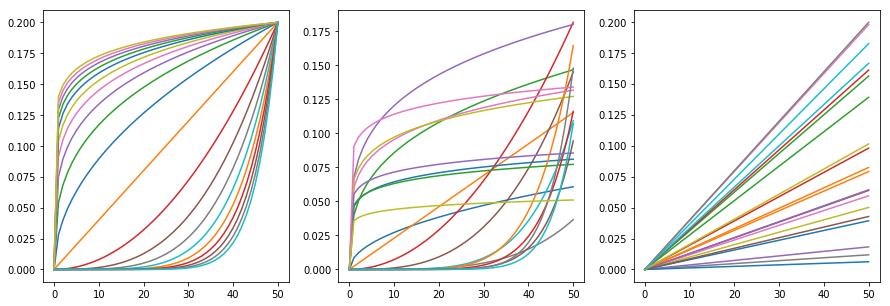

In [17]:
N=50
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
for i in range(10):
    plt.plot(strain_non_linear(N,1/(i+2)))
    plt.plot(strain_non_linear(N,i+1))
plt.subplot(1,3,2)
for i in range(10):
    plt.plot(strain_non_linear2(N,1/(i+2)))
    plt.plot(strain_non_linear2(N,i+1))
plt.subplot(1,3,3)
for i in range(20):
    plt.plot(strain_linear(N))
plt.show()

In [18]:
N=50
strains_train=[]
strains_test=[]

for i in range(100):
    strains_train.append(strain_linear(N))
for i in range(10):
    strains_test.append(strain_linear(N))
for j in range(5):
    for k in range(100):
        strains_train.append(strain_non_linear2(N,1/(j+2)))
        strains_train.append(strain_non_linear2(N,j+1))
    for k in range(10):
        strains_test.append(strain_non_linear2(N,1/(j+2)))
        strains_test.append(strain_non_linear2(N,j+1))

In [19]:
print("number for training:",int(len(strains_train)))
print("number for testing:",len(strains_test))

number for training: 1100
number for testing: 110


In [20]:
E = 200000
b = 0.001
A = 1000
a = 0.2

stress_train=[]
for obj in strains_train:
    rma=RMA_newton(obj)
    rma.activate(E,A,b,a)
    stress_train.append(rma.stress)
    
stress_test=[]
for obj in strains_test:
    rma=RMA_newton(obj)
    rma.activate(E,A,b,a)
    stress_test.append(rma.stress)

In [21]:
X_train=np.array(strains_train)
y_train=np.array(stress_train)
X_test=np.array(strains_test)
y_test=np.array(stress_test)

Here below, the construction of the curve we want to approximate

In [22]:
N=50
strain_init=0.2*np.array(range(N+1))/N

E = 200000
b = 0.001
A = 1000
a = 0.2

rma=RMA_newton(strain_init)
rma.activate(E,A,b,a)
stress_init=rma.stress

### II. Simple Model

In [41]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.colors import Colormap

#### a) Naive approach 1 : Multilayer Perceptron using sklearn API

In [15]:
mlp=MLP((51,143,51),alpha=0.0001,activation='tanh',learning_rate='adaptive',learning_rate_init=0.001,max_iter=20000)
#reg=LinearRegression()

In [14]:
mlp.fit(X_train,y_train)
#reg.fit(X_train,y_train)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(51, 143, 51), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=20000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
y_predict=mlp.predict(X_test)
#y_predict=reg.predict(X_test)

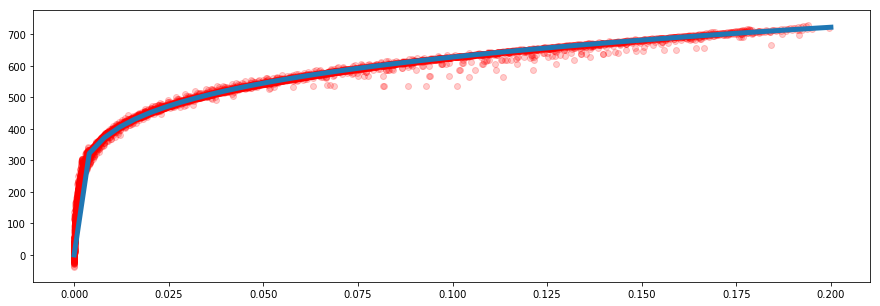

In [16]:
plt.plot(strain_init,stress_init,lw=5)
for i in range(110):
    plt.scatter(X_test[i,:],y_predict[i],color='red',alpha=0.2)

Results look relatively good so far. Implementation in Tensorflow below. Let us try another model with MultiTaskLasso

#### b) Naive approach 2 : LASSO APPROACH DOES NOT WORK =(

In [51]:
#model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', Lasso(alpha=0.01,max_iter=500))])
model = MultiTaskLasso(alpha=0.01,max_iter=20000)

In [52]:
# Normalizing inputs
std_1=StandardScaler()
std_2=StandardScaler()
std_1.fit(X_train)
std_2.fit(y_train)
X_train_new=std_1.transform(X_train)
y_train_new=std_2.transform(y_train)

In [53]:
model = model.fit(X_train_new, y_train_new)

In [54]:
y_predict = model.predict(std_1.transform(X_test))

In [55]:
y_predict.shape

(110, 51)

In [56]:
y_predict=y_predict*std_2.scale_+std_2.mean_

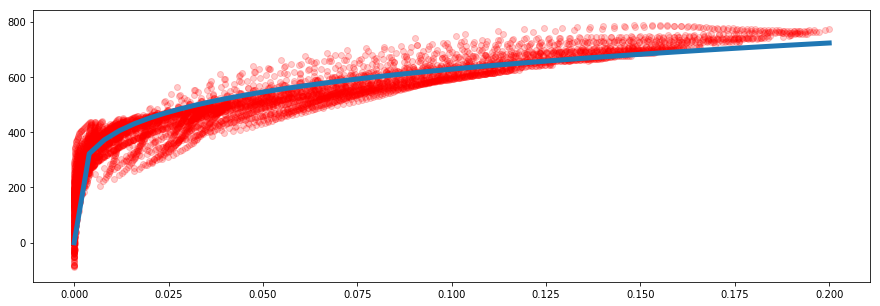

In [57]:
plt.plot(strain_init,stress_init,lw=5)
for i in range(0,110):
    plt.scatter(X_test[i,:],y_predict[i],color='red',alpha=0.2)

### III. Building the model in tensorflow for the monotonous case : Simple FeedForward NN

In [12]:
import tensorflow as tf
import numpy as np

In [17]:
tf.reset_default_graph()

# Define parameters for the model
learning_rate = 0.001
batch_size = 150
n_epochs = 3000
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Import Data Into the Model
with tf.name_scope('data'):
    train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train))
    train_data=train_data.shuffle(10000)
    train_data=train_data.batch(batch_size)
    
    test_data=tf.data.Dataset.from_tensor_slices((X_test,y_test))
    test_data=test_data.batch(batch_size)
    
    iterator = tf.data.Iterator.from_structure(train_data.output_types, train_data.output_shapes)
    
    strain, stress = iterator.get_next()
    
    train_init = iterator.make_initializer(train_data)
    test_init = iterator.make_initializer(test_data)
    
# Create weights, biases and model
with tf.name_scope('hidden_layer'):
    weights_1 = tf.get_variable(name='weights_1',shape=(51,149),initializer=tf.random_normal_initializer(0,0.01),dtype=tf.float64)
    bias_1 = tf.get_variable(name='bias_1',shape=(1,149),initializer=tf.zeros_initializer(),dtype=tf.float64)
    output_1 = tf.matmul(strain,weights_1) + bias_1
    activation = tf.nn.tanh(output_1,name='activation')
    
with tf.name_scope('output_layer'):
    weights_2 = tf.get_variable(name='weights_2',shape=(149,51),initializer=tf.random_normal_initializer(0,0.01),dtype=tf.float64)
    bias_2 = tf.get_variable(name='bias_2',shape=(1,51),initializer=tf.zeros_initializer(),dtype=tf.float64)
    output_2 = tf.matmul(activation,weights_2)+bias_2

# Define loss and optimizer
with tf.name_scope('loss'):
    MSE = tf.square(stress - output_2, name='mean_squared_error')
    loss = tf.reduce_mean(MSE)
    
with tf.name_scope('optimizer'):
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
with tf.name_scope('cost'):
    MSE_2 = tf.square(stress - output_2, name='mean_squared_error_2')
    cost = tf.reduce_mean(MSE_2,name='cost_testing')
    
with tf.name_scope('summaries'):
    tf.summary.scalar('loss_results',loss)
    tf.summary.histogram('ouput_layer_1_before_activation',output_1)
    tf.summary.histogram('output_layer_1_after_activation',activation)
    summary_op=tf.summary.merge_all()
    
# Create FileWriter to save sess graph
writer = tf.summary.FileWriter('./graphs_nn1', tf.get_default_graph())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_epoch=[]
    for i in range(n_epochs):
        sess.run(train_init)
        try:
            while True:
                _, summary = sess.run([optimizer, summary_op])
        except tf.errors.OutOfRangeError:
            pass
        writer.add_summary(summary, global_step=i)
        
        sess.run(test_init)
        try:
            while True:
                cost_batch = sess.run(cost)
                cost_epoch.append(cost_batch)
        except tf.errors.OutOfRangeError:
            pass
    
writer.close()

In [20]:
import os
print("tensorboard --logdir=\""+os.getcwd()+"/graphs_nn1\"")

tensorboard --logdir="/home/maxlavech/StressStrain_Project/graphs_nn1"


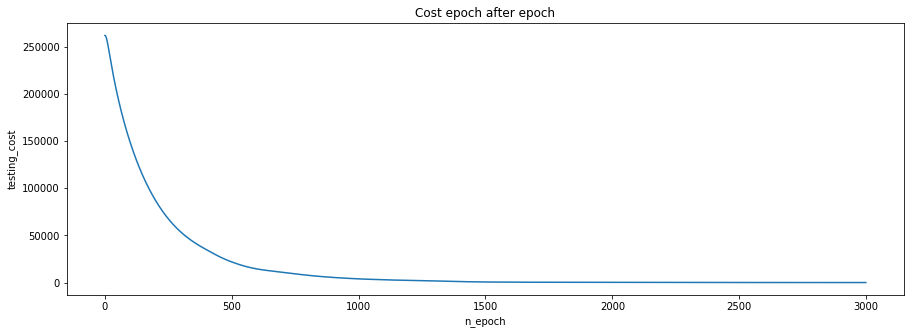

In [23]:
# Testing cost !
plt.plot(cost_epoch)
plt.title("Cost epoch after epoch")
plt.ylabel("testing_cost")
plt.xlabel("n_epoch")
plt.show()

#### Screenshots of Tensorboard

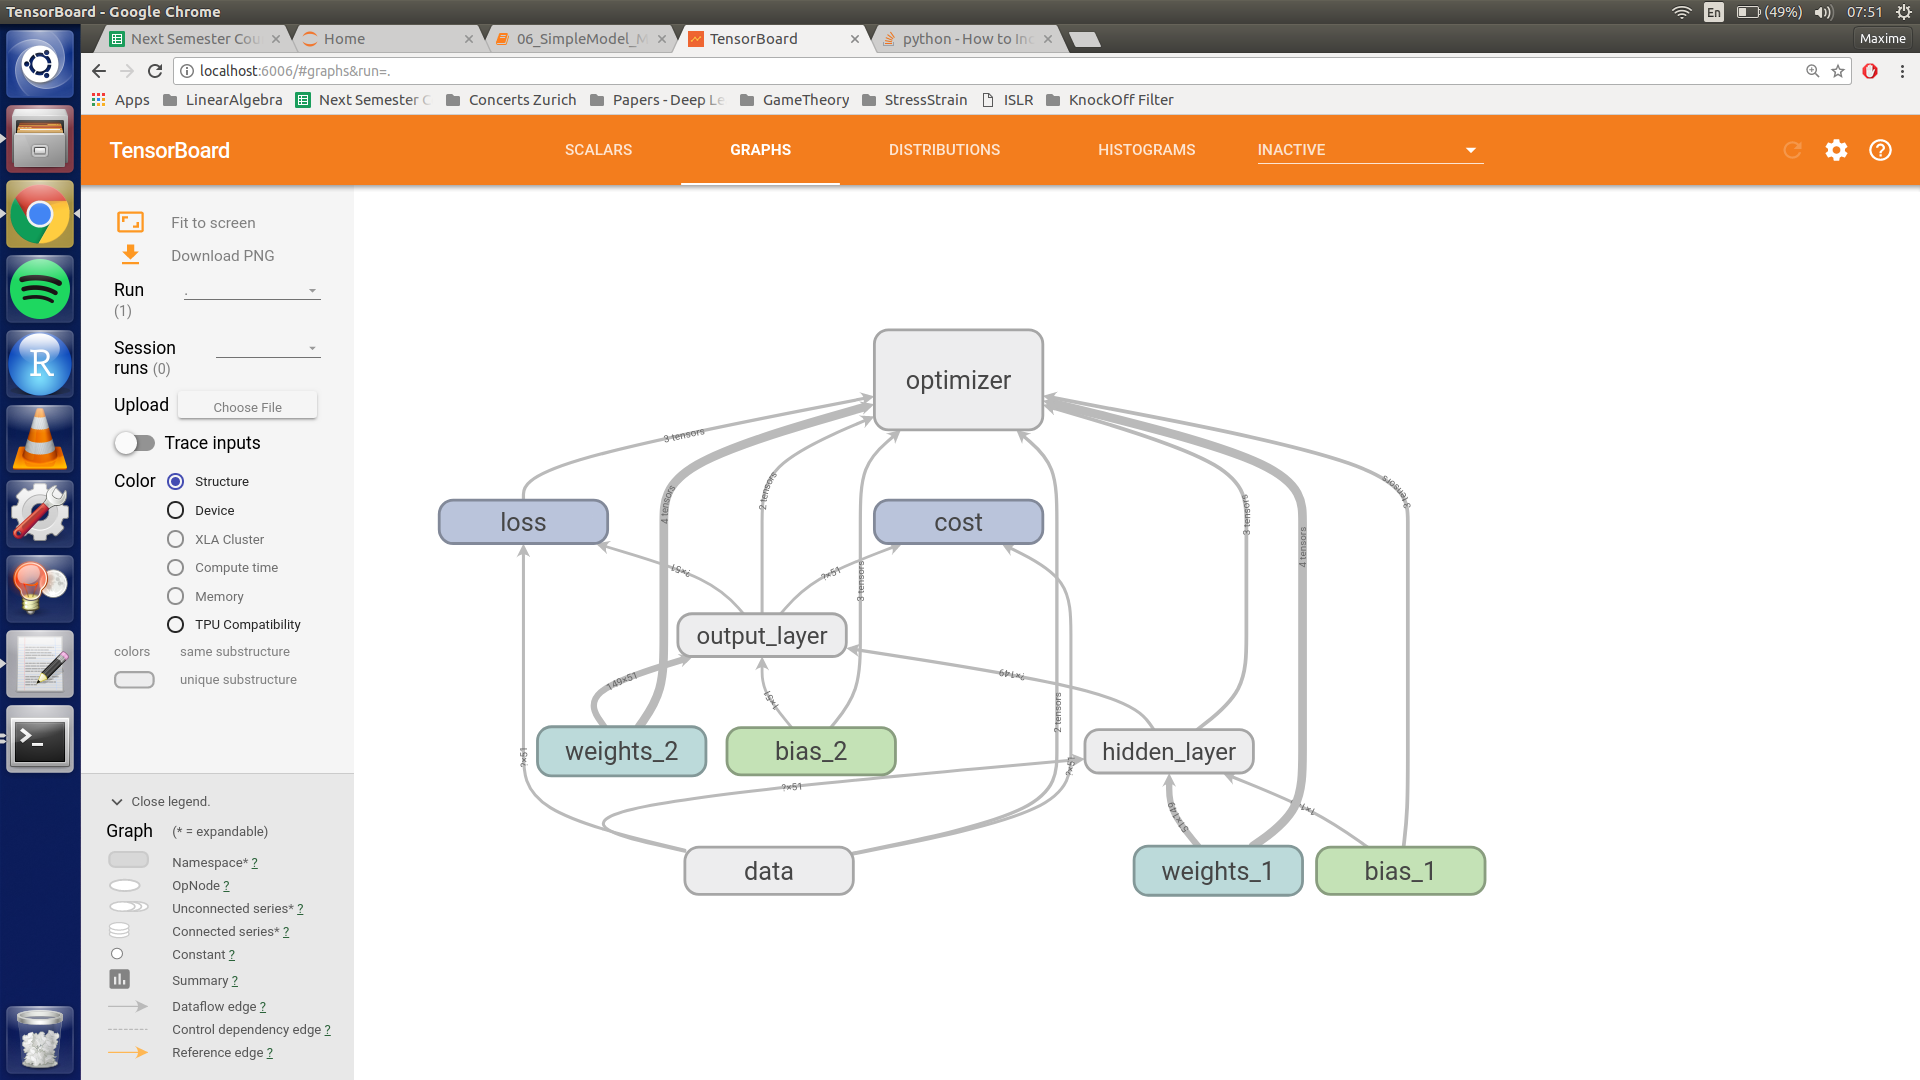

In [10]:
# Computational Graph
PATH = "/home/maxlavech/StressStrain_Project/"
Image(filename = PATH + "graph_nn1_test.png", width=1000, height=1000)

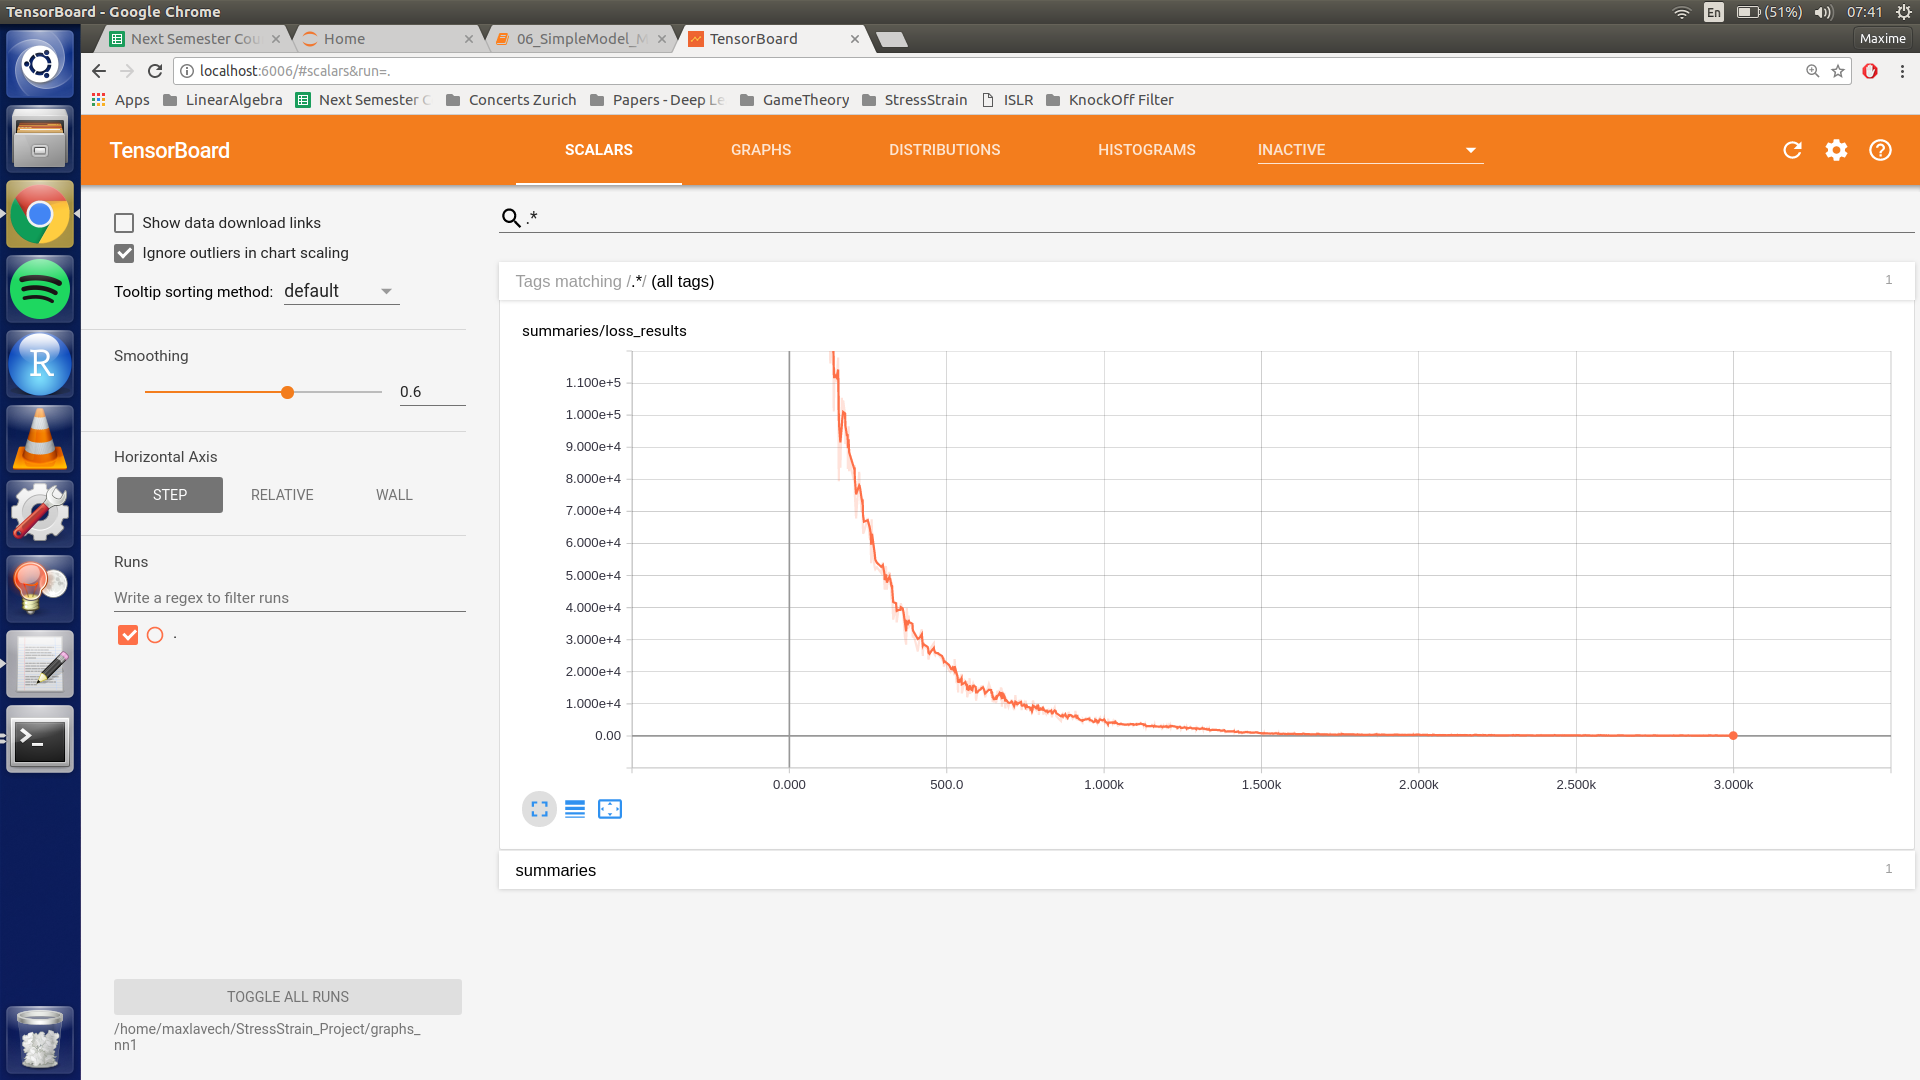

In [12]:
# Training Loss
PATH = "/home/maxlavech/StressStrain_Project/"
Image(filename = PATH + "loss_training_1.png", width=1000, height=1000)

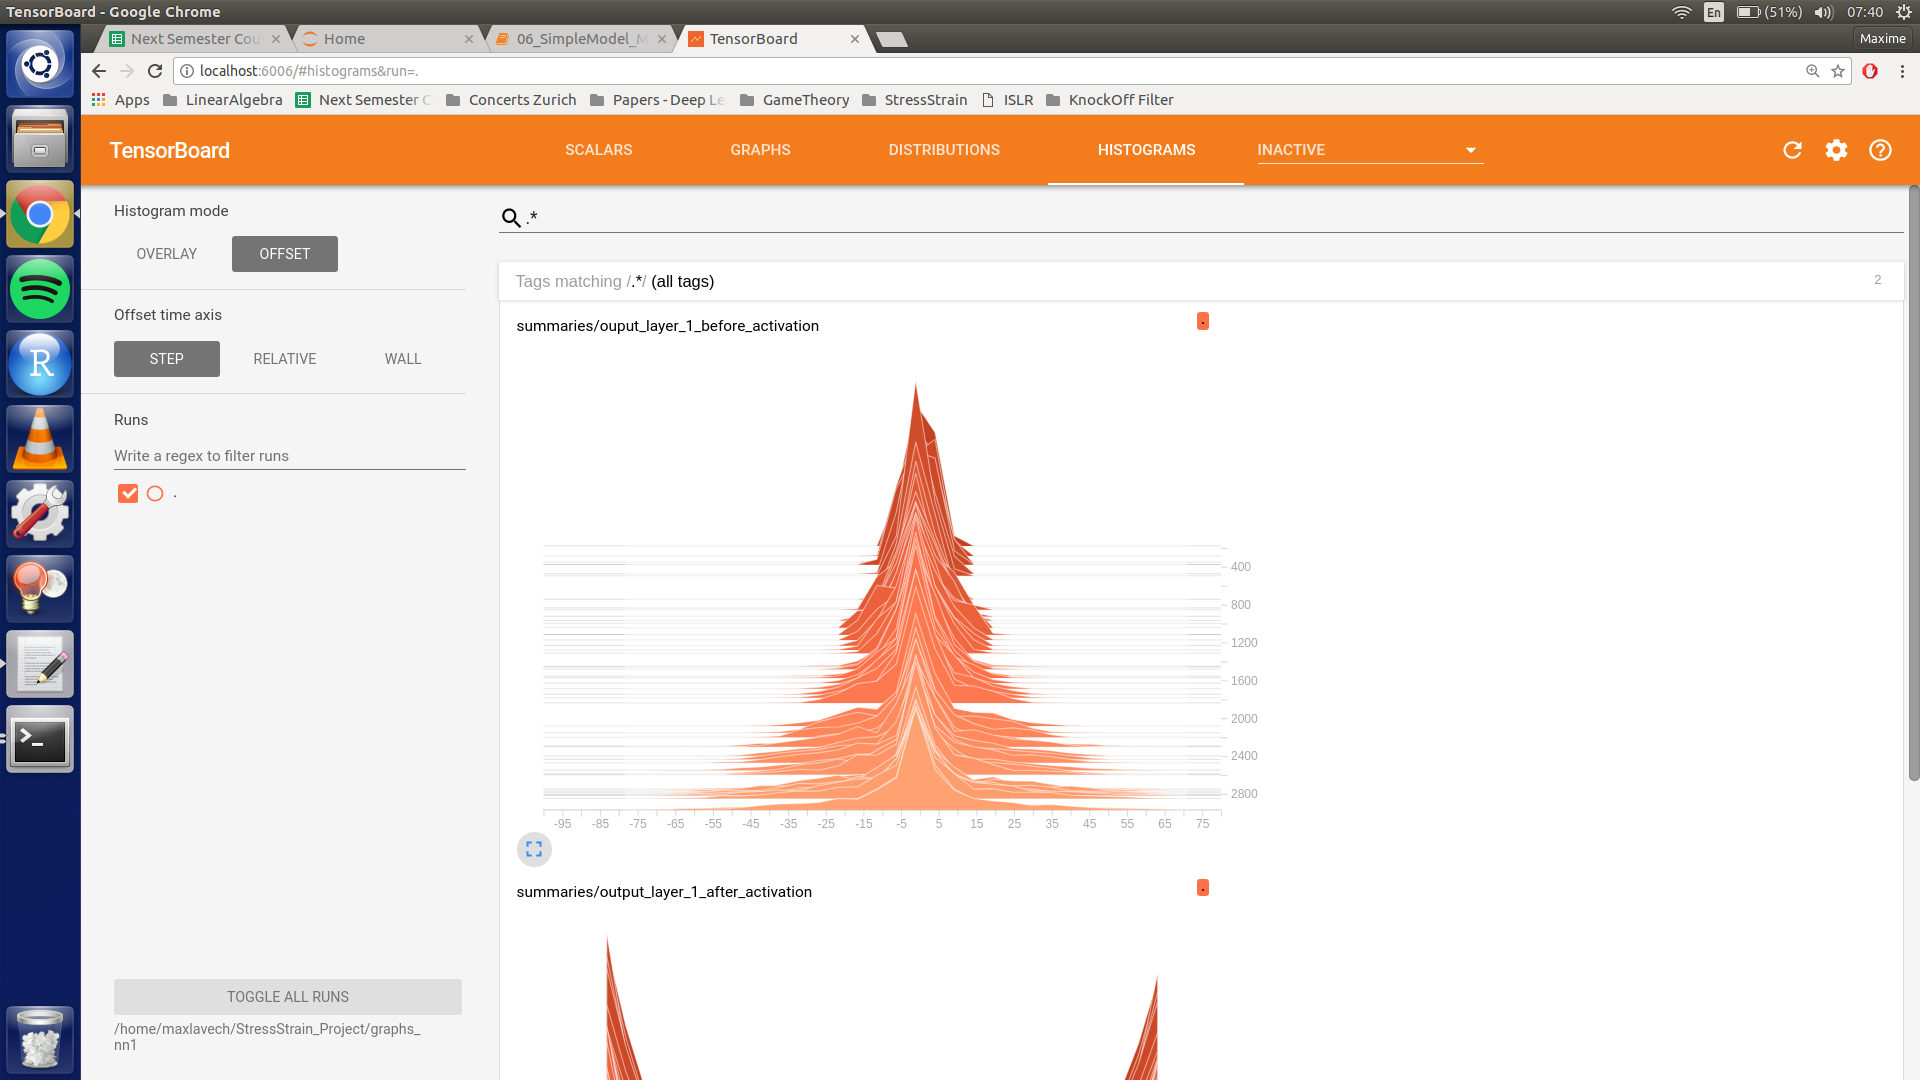

In [5]:
# Distribution of weights before activation
PATH = "/home/maxlavech/StressStrain_Project/"
Image(filename = PATH + "dist_b.png", width=1000, height=1000)

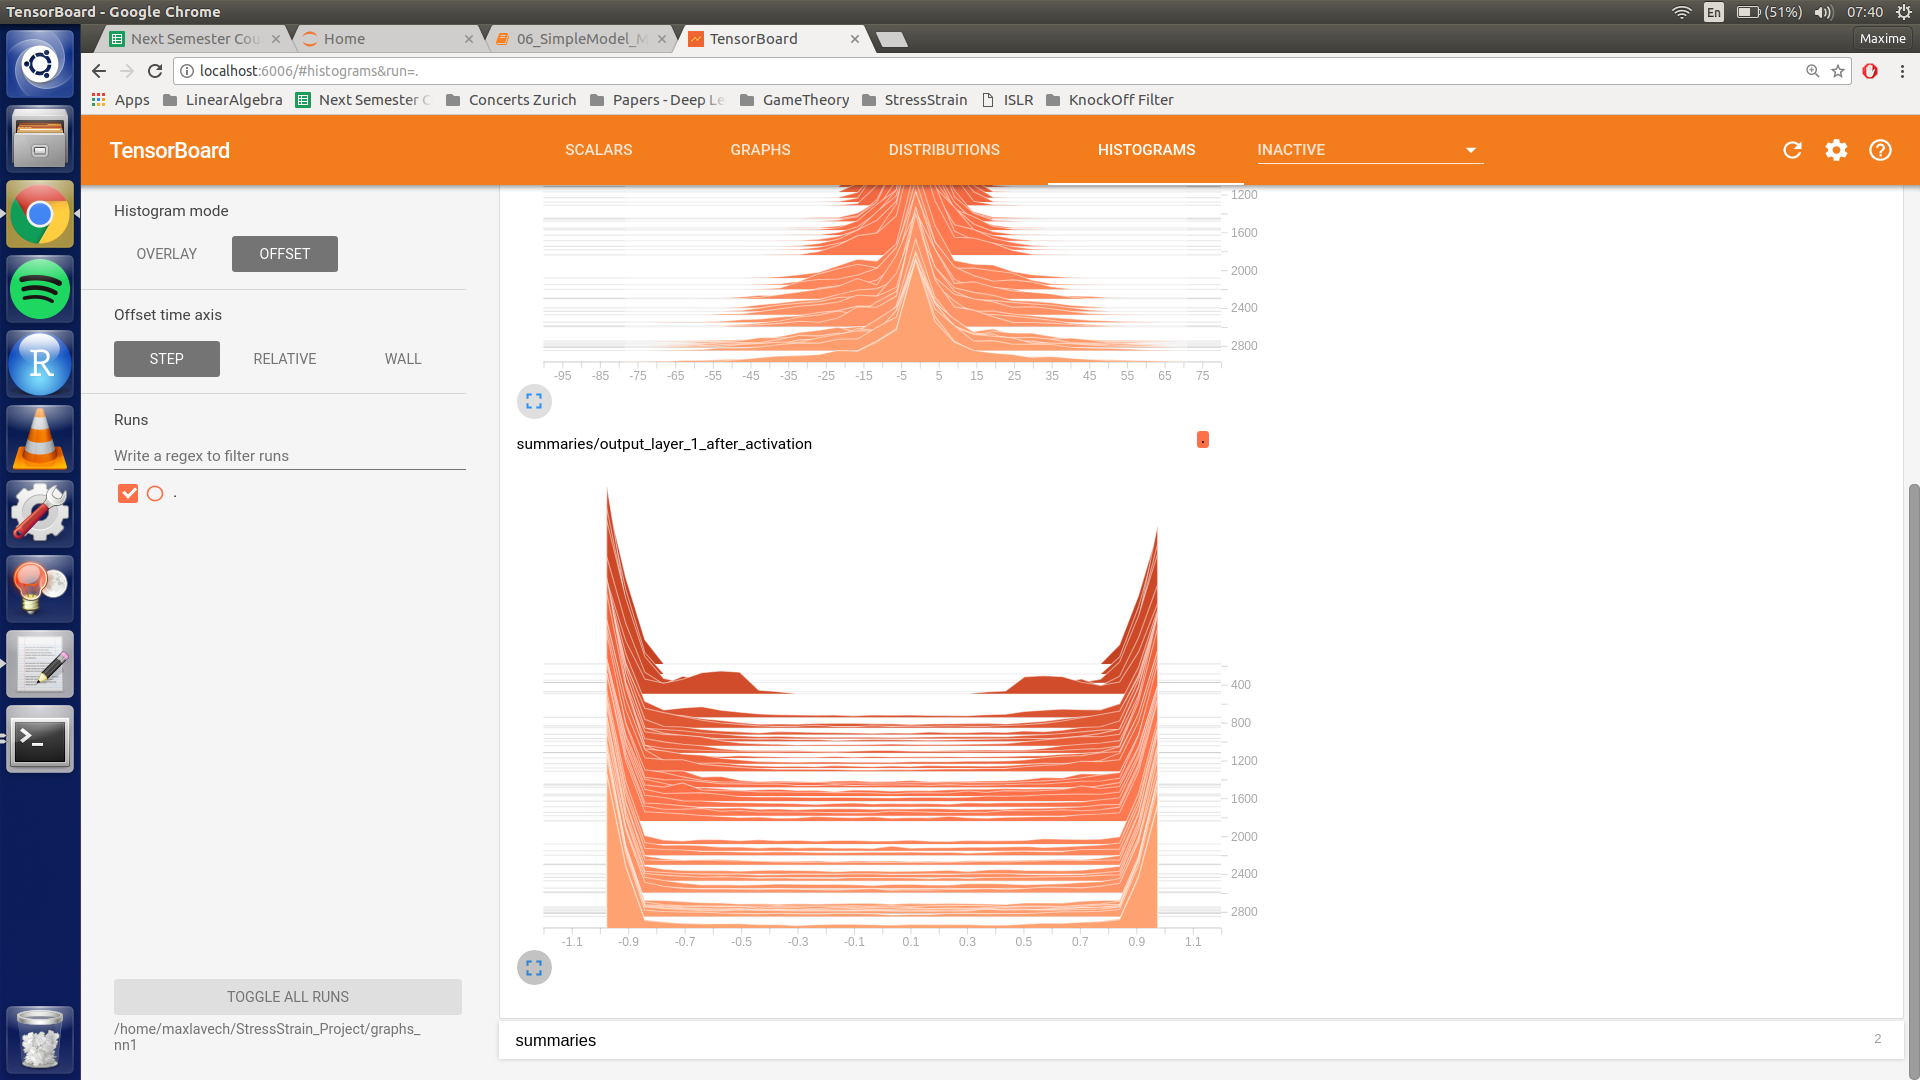

In [7]:
# Distribution of weights after activation
PATH = "/home/maxlavech/StressStrain_Project/"
Image(filename = PATH + "dist_a.png", width=1000, height=1000)

Note that this kind of architecture is usually strongly correlated with the idea of low bias, high variance. To achieve a better generalization, we should think of having a deeper neural network.